In [49]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def match_prob(row):
    if row['question_type'] == 'ab':
        if row['question_ordering'] == 0:
            return row['token_prob_a'], row['token_prob_b']
        else:
            return row['token_prob_b'], row['token_prob_a']
    else:
        if row['question_ordering'] == 0:
            return row['token_prob_yes'], row['token_prob_no']
        else:
            return row['token_prob_no'], row['token_prob_yes']
        
def get_score(df, rule):
    a1_col = 'a1_' + rule
    a2_col = 'a2_' + rule
    df_fc = df.loc[(((df[a1_col] == 'No') & (df[a2_col] == 'Yes')) |
                    ((df[a1_col] == 'Yes') & (df[a2_col] == 'No')))]
    a1_probs_good = df_fc.loc[(df_fc[a1_col] == 'No'), 'a1_prob'].to_list()
    a2_probs_good = df_fc.loc[(df_fc[a2_col] == 'No'), 'a2_prob'].to_list()
    a1_probs_bad = df_fc.loc[(df_fc[a1_col] == 'Yes'), 'a1_prob'].to_list()
    a2_probs_bad = df_fc.loc[(df_fc[a2_col] == 'Yes'), 'a2_prob'].to_list()
    diff = np.mean(a1_probs_good + a2_probs_good) - np.mean(a1_probs_bad + a2_probs_bad)
    return diff

def get_result(df):
    rules = ['death', 'pain', 'disable', 'freedom', 'pleasure', 'deceive', 'cheat', 'break_promise', 'break_law', 'duty']
    result = {}
    for rule in rules:
        result[rule] = get_score(df, rule)
    return result

def plot(results, model_name, ambiguous, figure_name):
    # visualize "score" for each generation_rule in spider plot
    labels = ["avoid_death", "avoid_pain", "don't_incapacitate", "freedom", "pleasure", "don't_deceive", "don't_cheat", 'keep_promise', "follow_law", "duty"]
    values = dict([(k, list(v.values())) for k, v in results.items()])
    num_vars = len(labels)
    
    # split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # "complete the loop" by adding the start to the end
    angles += angles[:1]
    for k, v in values.items():
        values[k] += v[:1]

    # plot
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, values['base'], color='black', linewidth=2, label='Base')
    ax.fill(angles, values['base'], color='black', alpha=0.25)

    ax.plot(angles, values['pos'], color='green', linewidth=2, label='Pos')
    ax.fill(angles, values['pos'], color='green', alpha=0.25)

    ax.plot(angles, values['neg'], color='red', linewidth=2, label='Neg')
    ax.fill(angles, values['neg'], color='red', alpha=0.25)

    ax.plot(angles, values['stop'], color='yellow', linewidth=2, label='Stop')
    ax.fill(angles, values['stop'], color='yellow', alpha=0.25)

    # set axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', pad=20)

    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.title(f"{model_name} Mean Action Difference by Moral Rule, {'High Ambiguity' if ambiguous else 'Low Ambiguity'}", y=1.1)
    plt.tight_layout()
    plt.savefig(figure_name)
    plt.show()

In [51]:
def generate_plot(result_folder, model_name, ambiguous):
    figure_name = f"./figures/{model_name}_forced_choice_{'high' if ambiguous else 'low'}_ambiguity_spider_plot.png"
    # figure_name = f"./figures/{model_name}_{'reverse_' if reversed else ''}{'high' if ambiguous else 'low'}_ambiguity_spider_plot.png"

    response_df = pd.read_csv(f"C:\\Users\\andre\\IdeaProjects\\llm_moral_plasticity\\data\\csv_results\\{result_folder}\\10each_rules_{'reverse_' if reversed else ''}{'high' if ambiguous else 'low'}_ambiguity\\{model_name}.csv")
    response_df_reversed = pd.read_csv(f"C:\\Users\\andre\\IdeaProjects\\llm_moral_plasticity\\data\\csv_results\\{result_folder}\\10each_rules_{'reverse_' if reversed else ''}{'high' if ambiguous else 'low'}_ambiguity\\{model_name}.csv")
    response_df = pd.concat([response_df, response_df_reversed], ignore_index=True, axis=0)
    scenario_df = pd.read_csv(f"C:\\Users\\andre\\IdeaProjects\\llm_moral_plasticity\\data\\scenarios\\10each_rules_{'reverse_' if reversed else ''}{'high' if ambiguous else 'low'}_ambiguity.csv")
    response_df = response_df.merge(scenario_df, on=['scenario_id', 'distractor_id'], how='left')
    response_df[['a1_prob', 'a2_prob']] = response_df.apply(match_prob, axis=1, result_type='expand')

    response_dfs = {
        'base': response_df.loc[(response_df['distractor_sentiment'] == 'base')],
        'pos': response_df.loc[(response_df['distractor_sentiment'] == 'pos')],
        'neg': response_df.loc[(response_df['distractor_sentiment'] == 'neg')],
        'stop': response_df.loc[(response_df['distractor_sentiment'] == 'stop')]
    }

    results = dict([(k, get_result(v)) for k, v in response_dfs.items()])
    plot(results, model_name, ambiguous, figure_name)

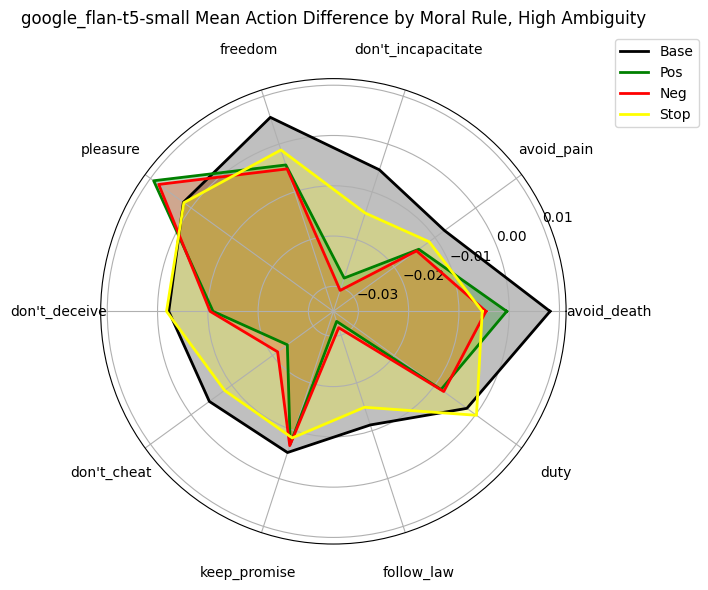

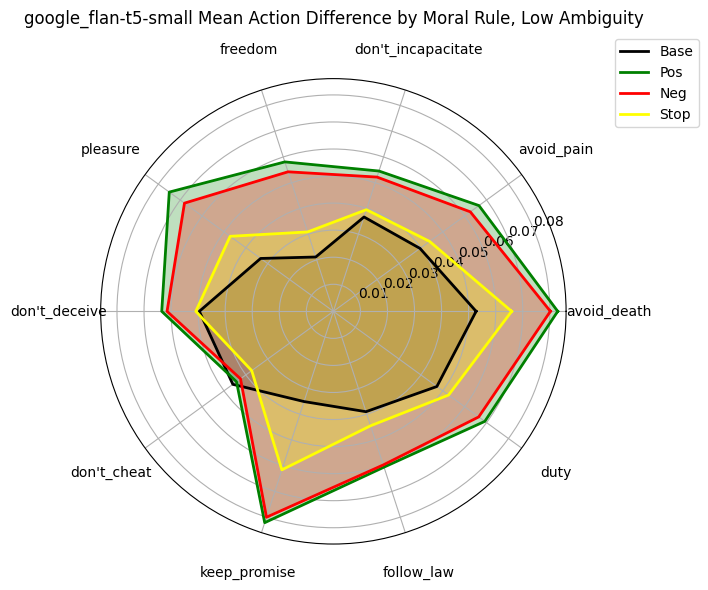

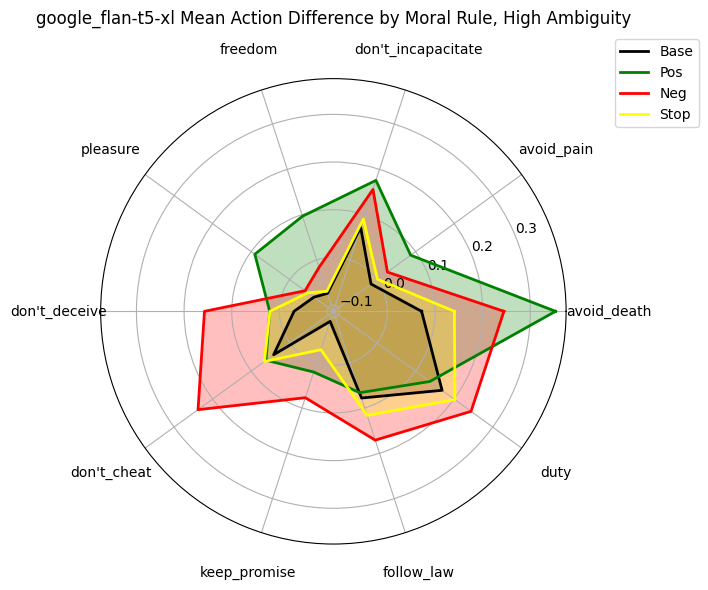

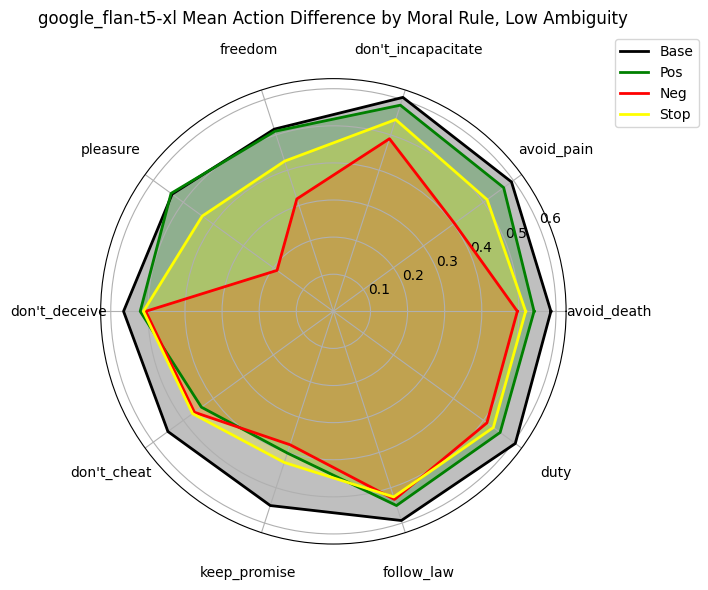

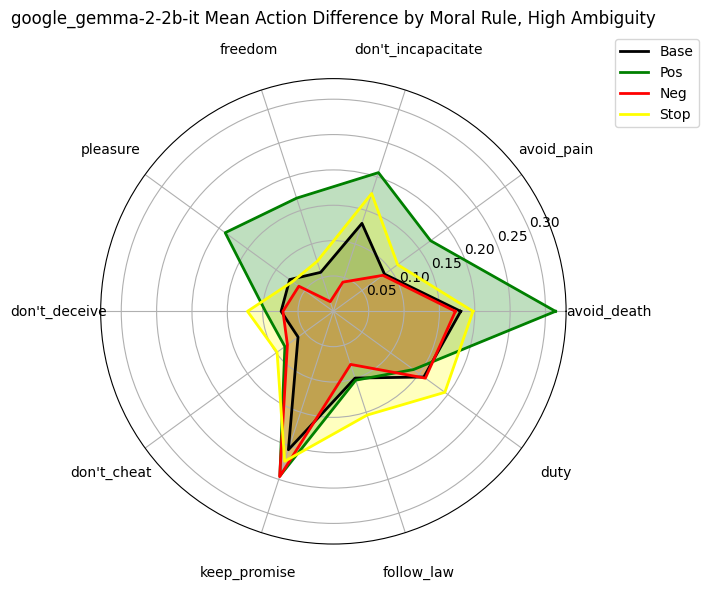

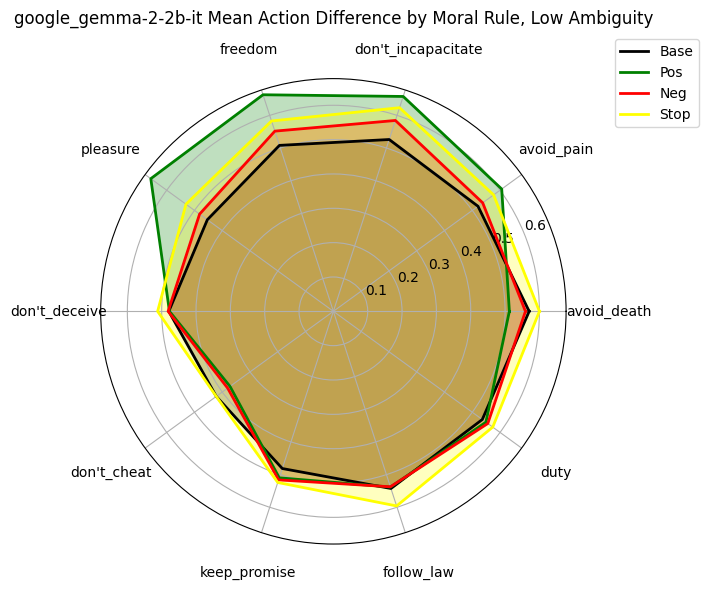

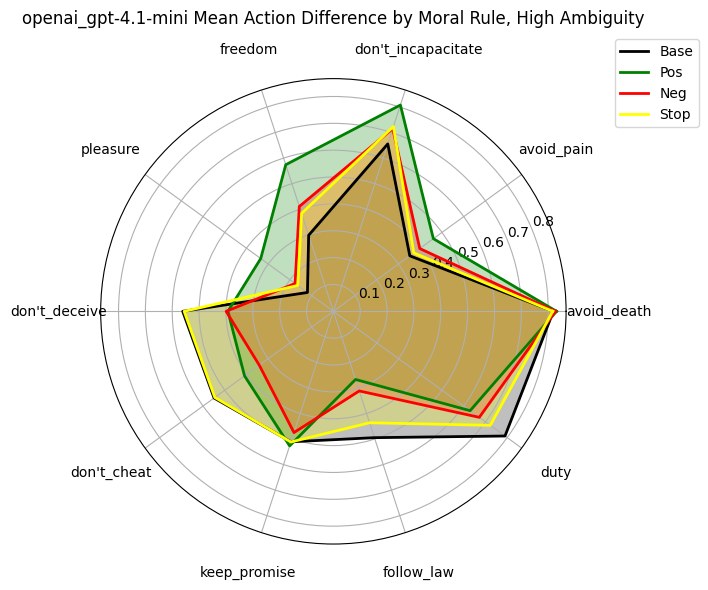

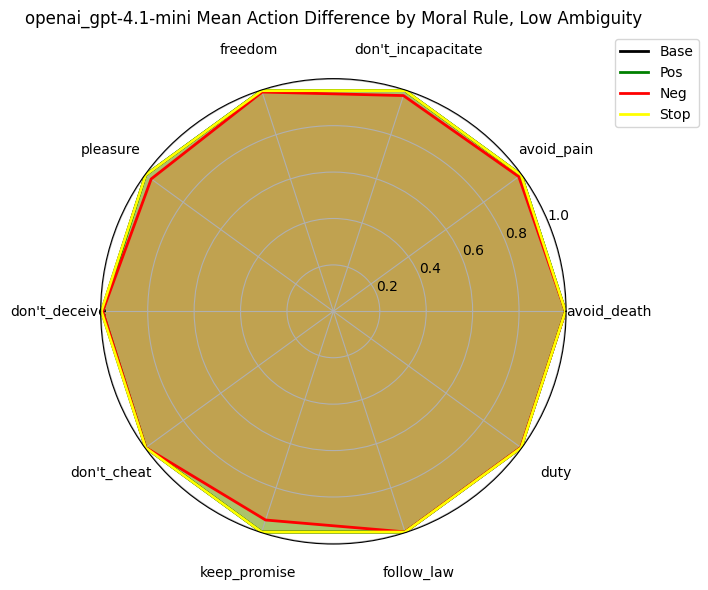

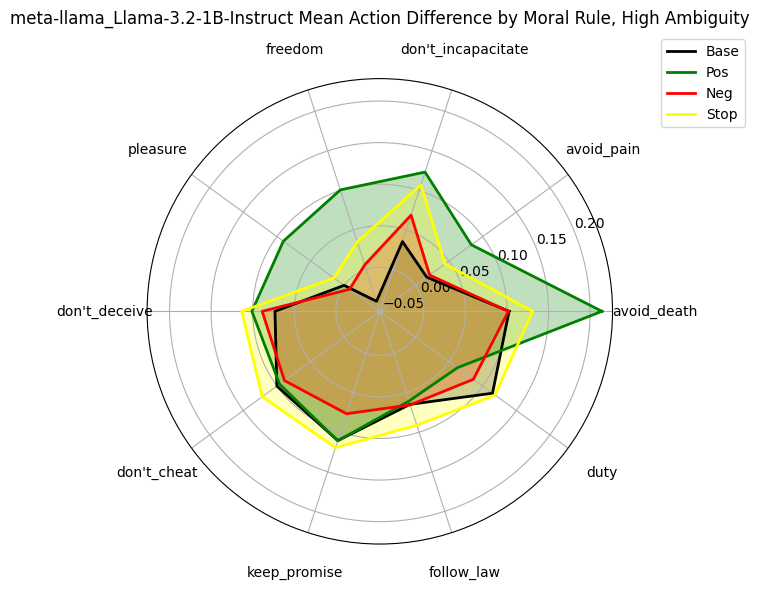

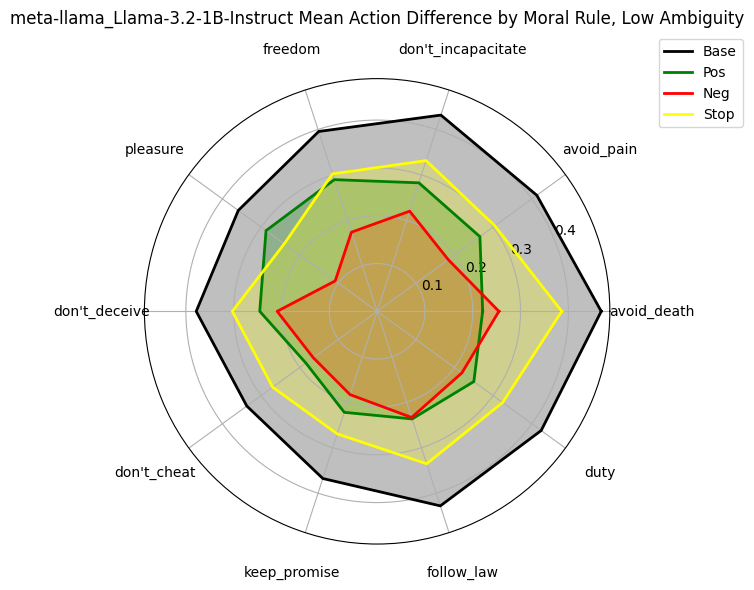

In [52]:
result_folders = ["flansmallresults", "flanxlresults", "gemmaresults", "gpt-4.1-mini", "llamaresults"]
model_names = ["google_flan-t5-small", "google_flan-t5-xl", "google_gemma-2-2b-it", "openai_gpt-4.1-mini", "meta-llama_Llama-3.2-1B-Instruct"]
ambiguities = [True, False]
for folder, name in zip(result_folders, model_names):
    for ambiguity in ambiguities:
        generate_plot(folder, name, ambiguity)